In [2]:
# Basic libraries
import pandas as pd
import numpy as np

from tqdm import tqdm

import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn library
import sklearn as sk
from sklearn.preprocessing import StandardScaler

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [4]:
def plot_feature(df, col):
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 2, 1)
    plt.plot(df['datetime'], df[col])
    # plt.xticks(np.arange(0, df.shape[0], 10000), rotation=90)
    plt.title(f'mean {col} over time')
    plt.show()

### Load data

In [6]:
df = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
# sort by pickup datetime and keep relevant columns
df = df.sort_values(by=['pickup_datetime'])[['pickup_datetime','passenger_count', 'trip_duration']]
# remove seconds from pickup datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.strftime('%Y-%m-%d %H:%M')
# group by pickup datetime and calculate mean passenger count and trip duration
df = df.groupby('pickup_datetime').agg({'passenger_count':'mean', 'trip_duration':'mean'}).reset_index()
df

,pickup_datetime,passenger_count,trip_duration
0,2016-01-01 00:00,3.000000,1071.500000
1,2016-01-01 00:01,1.833333,575.666667
2,2016-01-01 00:02,1.000000,877.500000
3,2016-01-01 00:03,1.000000,805.666667
4,2016-01-01 00:04,4.000000,645.500000
...,...,...,...
245454,2016-06-30 23:55,1.777778,930.000000
245455,2016-06-30 23:56,1.625000,728.000000
245456,2016-06-30 23:57,1.285714,964.285714
245457,2016-06-30 23:58,1.250000,736.625000


In [8]:
df.rename(columns={'pickup_datetime':'datetime'}, inplace=True)

In [9]:
plot_feature(df, 'trip_duration')
plot_feature(df, 'passenger_count')

KeyboardInterrupt: 

In [ ]:
# remove outliers
# df = df[df['trip_duration'] < 5000]
# plot_feature(df, 'trip_duration')
# plot_feature(df, 'passenger_count')

In [10]:
# passseneger_count by hour
df_hourly = df.copy()
df_hourly['datetime'] = pd.to_datetime(df_hourly['datetime'])
df_hourly['day'] = df_hourly['datetime'].dt.day
df_hourly['hour'] = df_hourly['datetime'].dt.hour
df_hourly['month'] = df_hourly['datetime'].dt.month
df_hourly['year'] = df_hourly['datetime'].dt.year

# aggregate by hour
df_hourly = df_hourly.groupby(['year', 'month', 'day', 'hour']).agg({'passenger_count':'mean', 'trip_duration':'mean'}).reset_index()
df_hourly.rename(columns={'passenger_count':'mean_passenger_count', 'trip_duration':'mean_trip_duration'}, inplace=True)
# assign datetime
df_hourly['datetime'] = pd.to_datetime(df_hourly[['year', 'month', 'day', 'hour']], format = '%Y-%m-%d %H')
df_hourly

,year,month,day,hour,mean_passenger_count,mean_trip_duration,datetime
0,2016,1,1,0,1.800624,951.140904,2016-01-01 00:00:00
1,2016,1,1,1,1.964432,964.531933,2016-01-01 01:00:00
2,2016,1,1,2,1.870531,830.429748,2016-01-01 02:00:00
3,2016,1,1,3,1.798788,1196.650547,2016-01-01 03:00:00
4,2016,1,1,4,1.891336,1058.525344,2016-01-01 04:00:00
...,...,...,...,...,...,...,...
4354,2016,6,30,19,1.591678,1063.264880,2016-06-30 19:00:00
4355,2016,6,30,20,1.660625,1171.971305,2016-06-30 20:00:00
4356,2016,6,30,21,1.742462,830.212926,2016-06-30 21:00:00
4357,2016,6,30,22,1.579830,1113.596407,2016-06-30 22:00:00


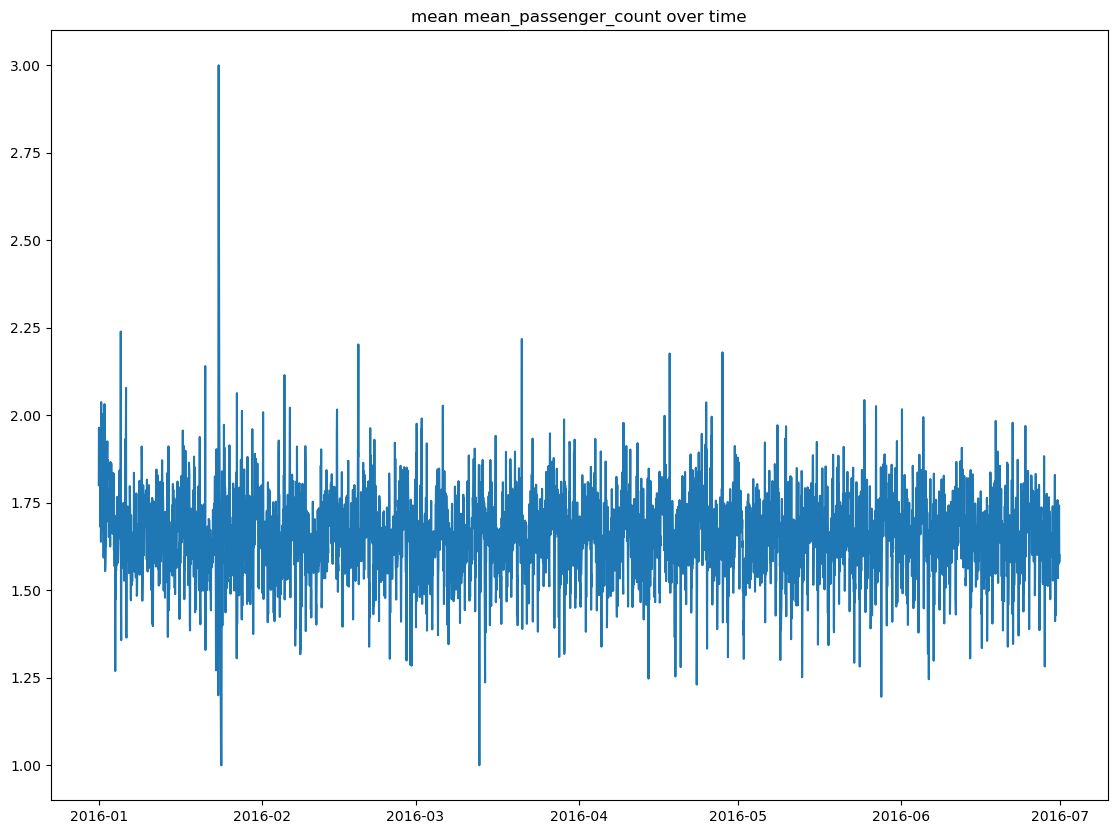

In [11]:
plot_feature(df_hourly, 'mean_passenger_count')

In [12]:
split_date_start = '2016-02-01'
# split_date_end = '2022-12-17'

train = df_hourly[(df_hourly['datetime'] >= split_date_start)]
train['datetime'] = pd.to_datetime(train['datetime'])
# train.set_index('datetime', inplace = True)

test = df_hourly[(df_hourly['datetime'] < split_date_start)]
test['datetime'] = pd.to_datetime(test['datetime'])
# test.set_index('datetime', inplace = True)

print('Training data shape: ', train.shape)
print('Testing data shape:  ', test.shape)

Training data shape:  (3624, 7)
Testing data shape:   (735, 7)


In [13]:
train = pd.DataFrame(train[['datetime','mean_passenger_count']]).set_index('datetime')
test = pd.DataFrame(test[['datetime','mean_passenger_count']]).set_index('datetime')

In [14]:
print("Test split percentage (%): ", str(test.shape[0]/(test.shape[0]+train.shape[0])*100))

Test split percentage (%):  16.86166551961459


In [15]:
scaled_train = train.copy(deep=True)
scaled_test = test.copy(deep=True)
    
# Setup scaler
scaler = StandardScaler()

scaled_train  = scaler.fit_transform( train.to_numpy().reshape(-1, 1))
scaled_train = pd.DataFrame(scaled_train, index=train.index, columns=train.columns)
scaled_test   = scaler.transform( test.to_numpy().reshape(-1, 1))
scaled_test = pd.DataFrame(scaled_test, index=test.index, columns=test.columns)

<AxesSubplot: xlabel='datetime'>

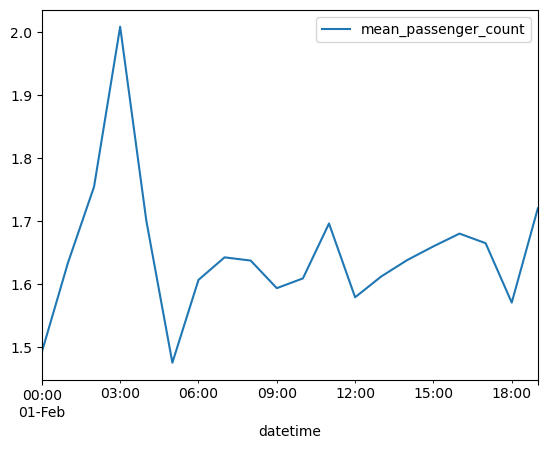

In [16]:
train[:20].plot()

### TranAD

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import dgl
from dgl.nn import GATConv
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder
torch.manual_seed(1)

from torch.utils.data import Dataset, DataLoader, TensorDataset

In [28]:
class color:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    RED = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [29]:
model_name = 'TranAD_Transformer'
dataset_name = 'taxi_nyc_data'

load data to torch format

In [30]:
import torch.utils.data as data_utils

train_tensor = torch.tensor(scaled_train.values, dtype=torch.float64)
train_loader = data_utils.DataLoader(train_tensor, batch_size = 64, shuffle = False)

test_tensor = torch.tensor(scaled_test.values, dtype=torch.float64)
test_loader = data_utils.DataLoader(test_tensor, batch_size = 64, shuffle = False)

In [31]:
train_tensor.shape, train_loader.dataset.shape

(torch.Size([3624, 1]), torch.Size([3624, 1]))

In [34]:
# Proposed Model (FCN) + Self Conditioning + Adversarial + MAML (VLDB 22)
class TranAD_Transformer(nn.Module):
	def __init__(self, feats, window_size):
		lr = 0.005
		
		super(TranAD_Transformer, self).__init__()
		self.name = 'TranAD_Transformer'
		self.lr = lr
		self.batch = 64
		self.n_feats = feats
		self.n_hidden = 32
		self.n_window = window_size
		self.n = 2 * self.n_feats * self.n_window

		self.transformer_encoder = nn.Sequential(
			nn.Linear(self.n, self.n_hidden), nn.ReLU(True),
			nn.Linear(self.n_hidden, self.n), nn.ReLU(True))
		
		self.transformer_decoder1 = nn.Sequential(
			nn.Linear(self.n, self.n_hidden), nn.ReLU(True),
			nn.Linear(self.n_hidden, 2 * feats), nn.ReLU(True))
		
		self.transformer_decoder2 = nn.Sequential(
			nn.Linear(self.n, self.n_hidden), nn.ReLU(True),
			nn.Linear(self.n_hidden, 2 * feats), nn.ReLU(True))
		self.fcn = nn.Linear(2 * feats, feats)

	def encode(self, src, c, tgt):
		src = torch.cat((src, c), dim=2)
		src = src.permute(1, 0, 2).flatten(start_dim=1)
		tgt = self.transformer_encoder(src)
		return tgt

	def forward(self, src, tgt):
		# Phase 1 - using zero-filled matrix (i.e. without anomaly scores)
		c = torch.zeros_like(src)
		x1 = self.transformer_decoder1(self.encode(src, c, tgt))
		x1 = x1.reshape(-1, 1, 2*self.n_feats).permute(1, 0, 2)
		x1 = self.fcn(x1)
		# Phase 2 - using anomaly scores from above
		c = (x1 - src) ** 2
		x2 = self.transformer_decoder2(self.encode(src, c, tgt))
		x2 = x2.reshape(-1, 1, 2*self.n_feats).permute(1, 0, 2)
		x2 = self.fcn(x2)
		return x1, x2

In [35]:
def convert_to_windows(data, n_window):
	windows = []; w_size = n_window
	for i, g in enumerate(data): 
		if i >= w_size: w = data[i-w_size:i]
		else: w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
		windows.append(w)
	return torch.stack(windows)

In [36]:
def save_model(model, optimizer, scheduler, epoch, accuracy_list):
        folder = f'tranAD_checkpoints/{model_name}_{dataset_name}/'
        os.makedirs(folder, exist_ok=True)
        file_path = f'{folder}/model.ckpt'
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'accuracy_list': accuracy_list}, file_path)

In [37]:
def backprop(epoch, model, data, dataO, optimizer, training = True):
	# l = nn.MSELoss(reduction = 'mean' if training else 'none')
	feats = dataO.shape[1]

	l = nn.MSELoss(reduction = 'none')
	data_x = torch.DoubleTensor(data); 
	# dataset = TensorDataset(data_x, data_x)
	dataset = data_x
	bs = model.batch if training else len(data)
	# dataloader = DataLoader(dataset, batch_size = bs)
	n = epoch + 1; 
	l1s, l2s = [], []
	if training:
		local_bs = dataset.size(dim=0)			
		# set window
		window = dataset.permute(1, 0, 2)
		
		# set sequence
		elem = window[-1, :, :].view(1, local_bs, feats)
		z = model(window, elem)
		# l1 = l(z, elem) if not isinstance(z, tuple) else (1 / n) * l(z[0], elem) + (1 - 1/n) * l(z[1], elem)
		l2_tmp = l(z[0], elem) + l(z[1], elem) # phase1 & phase2 addition of losses for real vs reconstructed outputs
		if isinstance(z, tuple): z = z[1]
		
		# calculate mean reconstruction loss
		loss = torch.mean(l2_tmp)

		optimizer.zero_grad()
		loss.backward(retain_graph=True)
		optimizer.step()

		l2s.append(loss)
		l2_tmp = torch.Tensor()

		return loss.item()
	else:
		local_bs = dataset.size(dim=0) 
		window = dataset.permute(1, 0, 2)
		elem = window[-1, :, :].view(1, local_bs, feats)
		z = model(window, elem)
		if isinstance(z, tuple): z = z[1]
		loss = l(z, elem)[0]
		return loss.detach().numpy(), z.detach().numpy()[0]

In [38]:
def plot_accuracies(accuracy_list, folder):
	os.makedirs(f'plots/{folder}/', exist_ok=True)
	trainAcc = [i[0] for i in accuracy_list]
	lrs = [i[1] for i in accuracy_list]
	plt.xlabel('Epochs')
	plt.ylabel('Average Training Loss')
	plt.plot(range(len(trainAcc)), trainAcc, label='Average Training Loss', linewidth=1, linestyle='-', marker='.')
	plt.twinx()
	plt.plot(range(len(lrs)), lrs, label='Learning Rate', color='r', linewidth=1, linestyle='--', marker='.')
	plt.savefig(f'plots/{folder}/training-graph.pdf')
	plt.show()

In [39]:

def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [40]:
def plotter(name, y_true, y_pred, ascore, labels):
	if 'TranAD' in name: y_true = torch.roll(y_true, 1, 0)
	os.makedirs(os.path.join('plots', name), exist_ok=True)
	for dim in range(y_true.shape[1]):
		y_t, y_p, l, a_s = y_true[:, dim], y_pred[:, dim], labels[:, dim], ascore[:, dim]
		fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
		ax1.set_ylabel('Value')
		ax1.set_title(f'Dimension = {dim}')
		# if dim == 0: np.save(f'true{dim}.npy', y_t); np.save(f'pred{dim}.npy', y_p); np.save(f'ascore{dim}.npy', a_s)
		ax1.plot(smooth(y_t), linewidth=0.2, label='True')
		ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
		ax3 = ax1.twinx()
		ax3.plot(l, '--', linewidth=0.3, alpha=0.5)
		ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3)
		if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
		ax2.plot(smooth(a_s), linewidth=0.2, color='g')
		ax2.set_xlabel('Timestamp')
		ax2.set_ylabel('Anomaly Score')
		plt.close()

In [41]:
def plot_accuracy_mean(accuracy_list, folder):
	os.makedirs(f'plots/{folder}/', exist_ok=True)
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	plt.plot(range(len(accuracy_list)), accuracy_list, label='Average Training Loss', linewidth=1, linestyle='-', marker='.')
	plt.show()

In [42]:
window_size = 20
model = TranAD_Transformer(train.shape[1], window_size)
model.double() # command to allow double tensor feed

TranAD_Transformer(
  (transformer_encoder): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=40, bias=True)
    (3): ReLU(inplace=True)
  )
  (transformer_decoder1): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=2, bias=True)
    (3): ReLU(inplace=True)
  )
  (transformer_decoder2): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=2, bias=True)
    (3): ReLU(inplace=True)
  )
  (fcn): Linear(in_features=2, out_features=1, bias=True)
)

In [43]:
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters() , lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
fname = f'tranAD_checkpoints/f{model_name}_{dataset_name}/model.ckpt'

In [47]:
from time import time

print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
epoch = -1; 
accuracy_list = []
accuracy_list_mean_per_epoch = [] 

### Training phase
print(f'{color.HEADER}Training {model_name} on {dataset_name}{color.ENDC} data')
num_epochs = 200; 
e = epoch + 1; 
sum = 0 
start = time()
for e in tqdm(list(range(epoch+1, epoch+num_epochs+1))):
    for batch in train_loader:
        # print("feeding batch number:" + str((sum+64))/len(train_loader)))
        trainW = batch
        trainS = trainW
        trainW = convert_to_windows(trainW, model.n_window)
        lossMiniBatch = backprop(e, model, trainW, trainS, optimizer)
        # accuracy_list.append((lossT, lr))
        accuracy_list.append(lossMiniBatch)
    accuracy_list_mean_per_epoch.append(np.mean(accuracy_list))
    accuracy_list = []
    # tqdm.write(f'Epoch {e},\tMSE = {accuracy_list_mean_per_epoch[-1]}')

    scheduler.step()

print(color.BOLD+'Training time: '+"{:10.4f}".format(time()-start)+' s'+color.ENDC)
save_model(model, optimizer, scheduler, e, accuracy_list_mean_per_epoch)

Creating new model: TranAD_Transformer
Training TranAD_Transformer on taxi_nyc_data data


100%|██████████| 200/200 [00:14<00:00, 14.16it/s]

Training time:    14.1301 s


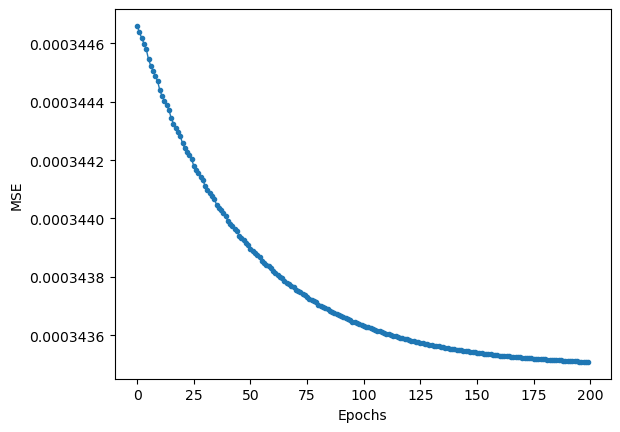

In [48]:
plot_accuracy_mean(accuracy_list_mean_per_epoch, f'{model_name}_{dataset_name}')

In [49]:
test_tensor
testW = convert_to_windows(test_tensor, model.n_window)


In [56]:
### Testing phase
from sklearn import metrics


testS = test_tensor
testW = convert_to_windows(test_tensor, window_size)

torch.zero_grad = True
model.eval()
print(f'{color.HEADER}Testing {model_name} on {dataset_name}{color.ENDC} transformer dataset')
loss, y_pred = backprop(0, model, testW, testS, optimizer, training=False)

print(f'{color.BOLD}MAE on test data: {np.mean(loss)}{color.ENDC}')
# estiamte MSE
print(f'{color.BOLD}MSE on test data: {np.mean(loss**2)}{color.ENDC}')
# estimate R-Squared
print(f'{color.BOLD}R-Squared on test data: {metrics.r2_score(testS.detach().numpy(), y_pred)}{color.ENDC}')
# estimate SMAPE
print(f'{color.BOLD}SMAPE on test data: {np.mean(np.abs(testS.detach().numpy() - y_pred) / (np.abs(testS.detach().numpy()) + np.abs(y_pred)))}{color.ENDC}')


Testing TranAD_Transformer on taxi_nyc_data transformer dataset
MAE on test data: 0.0015259645183873256
MSE on test data: 0.00020552632925340816
R-Squared on test data: -0.3972116878694183
SMAPE on test data: 0.622913843458124


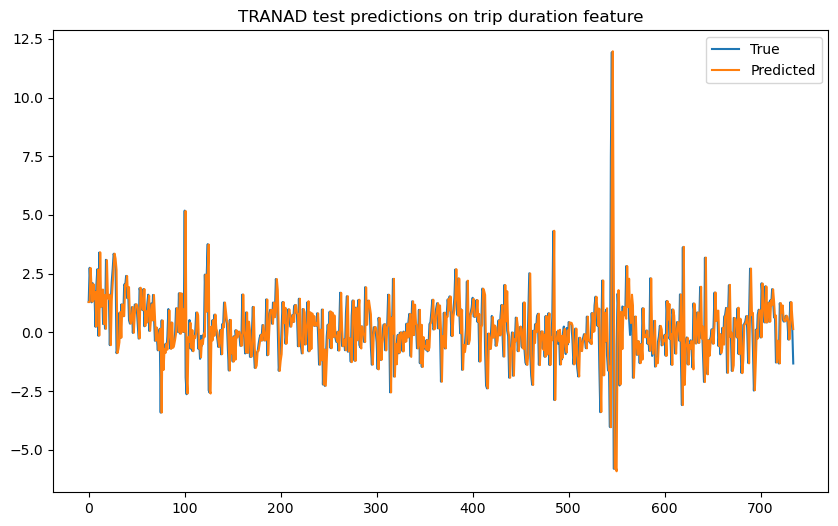

In [57]:
# SCALE FIRST!!!!


plt.figure(figsize=(10,6))
plt.title(f'TRANAD test predictions on trip duration feature')
plt.plot(test_tensor[:,0], label='True')
plt.plot(y_pred[:,0], label='Predicted')
plt.legend()
plt.show()
